In [1]:
# Load key libraries / functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
import os

In [2]:
# Start a Spark Session
spark = (
    SparkSession.builder \
        .appName("PySPARK - DataCamp Tutorial") \
        .config("spark.memory.offHeap.enabled", "true") \
        .config("spark.memory.offHeap.size", "10g") \
        .getOrCreate()
)
#spark = SparkSession.builder.getOrCreate()
print(spark.version)

25/02/16 12:50:18 WARN Utils: Your hostname, Baboymas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.134 instead (on interface en0)
25/02/16 12:50:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/16 12:50:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.5.4


In [3]:
# Load e-commerce data from DataCamp github as DataFrame
url_ecom = "https://raw.githubusercontent.com/brl0/datacamp_courses/refs/heads/master/datacamp_courses.csv"
file_ecom = "../../data/online_retail.csv"
#file_ecom = "../../data/datacamp_courses.csv"

# Download the file if it does not exist
if not os.path.exists(file_ecom):
	os.makedirs(os.path.dirname(file_ecom), exist_ok=True)
	urllib.request.urlretrieve(url_ecom, file_ecom)

df = spark.read.option("header", "true").option("escape", "\"").csv(file_ecom)

25/02/16 12:50:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
# Show schema
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
# Export dataframe
df.show(5, 0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

## Data Exploratory

In [6]:
# Count number of rows
df.count()

541909

In [7]:
# Number of customers
df.select('CustomerID').distinct().count()

4373

In [9]:
df.where(col('CustomerID').isNull()).select('CustomerID').distinct().count()

1

In [10]:
df = df.where(col('CustomerID').isNotNull())

In [11]:
# Number of customers by country
df.groupBy('Country').agg(countDistinct('CustomerID').alias('CCount')).orderBy(desc('CCount')).show(5)

+--------------+------+
|       Country|CCount|
+--------------+------+
|United Kingdom|  3950|
|       Germany|    95|
|        France|    87|
|         Spain|    31|
|       Belgium|    25|
+--------------+------+
only showing top 5 rows



In [13]:
df.select('InvoiceDate').distinct().show(5)

+--------------+
|   InvoiceDate|
+--------------+
| 12/2/10 16:45|
|  12/7/10 9:57|
| 12/9/10 14:30|
|12/12/10 11:37|
|12/14/10 12:17|
+--------------+
only showing top 5 rows



In [14]:
# Get the latest purchase

## reset time parser to legacy
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

## Add column date based on invoice date
df = df.where(col('InvoiceDate').isNotNull()).withColumn('date', to_timestamp('InvoiceDate', 'yyyy/MM/dd HH:mm'))

df.show(5, 0)
df.select(min('date')).show()
df.select(max('date')).show()

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|0012-01-10 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|0012-01-10 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|0012-01-10 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|0012-01-10 08:26:00|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEA

+-------------------+
|          min(date)|
+-------------------+
|0001-04-11 10:00:00|
+-------------------+



+-------------------+
|          max(date)|
+-------------------+
|0012-12-10 16:20:00|
+-------------------+



# Pre-processing

In [15]:
# Schema
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)



# Costumer Segmentation
## RFM (Recency, Frequency, Monetary)

In [16]:
# Recency
df = df.withColumn('from_date', lit('12/1/10 08:26'))
df = df.withColumn('from_date', to_timestamp('from_date', 'yy/MM/dd H:mm'))

df2 = df.withColumn('from_date', to_timestamp(col('from_date'))).withColumn('recency', col('date').cast('long') - col('from_date').cast('long'))


In [17]:
df2.show(10, 0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |recency     |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|0012-01-10 08:26:00|2012-01-10 08:26:00|-63113904238|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|0012-01-10 08:26:00|2012-01-10 08:26:00|-63113904238|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|0012-01-10 08:26:00|2012-01-10 08:26:00|

In [18]:
# Last purchases for each customer
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')), on='recency', how='leftsemi')

df2.show(5, 0)

+------------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency     |InvoiceNo|StockCode|Description                       |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+------------+---------+---------+----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|-63113903698|536369   |21756    |BATH BUILDING BLOCK WORD          |3       |12/1/10 8:35|5.95     |13047     |United Kingdom|0012-01-10 08:35:00|2012-01-10 08:26:00|
|-63113902198|536371   |22086    |PAPER CHAIN KIT 50'S CHRISTMAS    |80      |12/1/10 9:00|2.55     |13748     |United Kingdom|0012-01-10 09:00:00|2012-01-10 08:26:00|
|-63113900278|536375   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER|6       |12/1/10 9:32|2.55     |17850     |United Kingdom|0012-01-10 09:32:00|2012-01-10 08

In [19]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [20]:
# Purchase Frequency
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency')).orderBy(desc('frequency'))

df_freq.show(10, 0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|14096     |530      |
|14730     |314      |
|17841     |277      |
|14535     |238      |
|12378     |219      |
|14911     |210      |
|14456     |203      |
|18022     |191      |
|13521     |183      |
|13174     |169      |
+----------+---------+
only showing top 10 rows



In [21]:
df3 = df2.join(df_freq, on = 'CustomerID', how = 'inner')

df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [25]:
# Monetory Value
m_val = df3.withColumn('TotalAmount', col('Quantity') * col('UnitPrice'))

m_val.select('CustomerID', 'TotalAmount').orderBy(desc('TotalAmount')).show(5)

+----------+------------------+
|CustomerID|       TotalAmount|
+----------+------------------+
|     15749|            4522.5|
|     15195|            3861.0|
|     12755|3794.3999999999996|
|     15749|3314.9999999999995|
|     16210|            3254.4|
+----------+------------------+
only showing top 5 rows



In [26]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

m_val.orderBy(desc('monetary_value')).show(5, 0)

+----------+-----------------+
|CustomerID|monetary_value   |
+----------+-----------------+
|14646     |8361.8           |
|15749     |7837.5           |
|14096     |7835.540000000014|
|12357     |6207.669999999996|
|12409     |6207.079999999999|
+----------+-----------------+
only showing top 5 rows



In [27]:
df_final = m_val.join(df3, on = 'CustomerID', how = 'inner')
df_final = df_final.select(['CustomerID', 'recency', 'frequency', 'monetary_value']).distinct()
df_final.show(10, 0)

+----------+------------+---------+------------------+
|CustomerID|recency     |frequency|monetary_value    |
+----------+------------+---------+------------------+
|16250     |-63113898658|14       |226.14            |
|15574     |-63111199438|121      |375.65            |
|15271     |-63092803378|24       |111.75            |
|15555     |-63092792218|37       |620.3499999999998 |
|17757     |-63090201238|49       |385.25            |
|13187     |-63447802378|37       |236.01999999999995|
|13107     |-63437284918|21       |566.8400000000001 |
|16303     |-63437278438|35       |827.1799999999998 |
|13174     |-63103421158|169      |1415.9700000000003|
|17128     |-63439878478|14       |157.09            |
+----------+------------+---------+------------------+
only showing top 10 rows



## Customer Segmentation

In [ ]:
# Standardization

In [28]:
assemble = VectorAssembler(
    inputCols=[
    'recency','frequency','monetary_value'
    ],
    outputCol='features'
)

assembled_data = assemble.transform(df_final)

In [29]:
scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

In [30]:
data_scale_output.select('standardized').show(2,truncate=False)

+------------------------------------------------------------+
|standardized                                                |
+------------------------------------------------------------+
|[-629.1525130203162,0.45890203194255746,0.07645669520731259]|
|[-629.125605776709,3.9662247046463897,0.12700520719300865]  |
+------------------------------------------------------------+
only showing top 2 rows



In [31]:
# ML Model - K-Means
## Number of clusters: use of elbow-method

max_k = 6

cost = np.zeros(max_k)

evaluator = ClusteringEvaluator(
    predictionCol='prediction',
    featuresCol='standardized',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean'
)

for i in range(2, max_k):
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

25/02/16 12:55:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/02/16 12:55:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


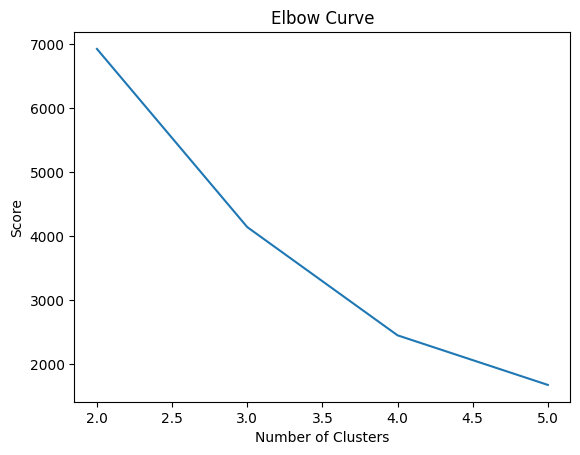

In [32]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2, max_k)
df_cost.insert(0, 'cluster', new_col)
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [33]:
# K-Means Clustering Model
KMeans_algo = KMeans(featuresCol='standardized', k=4)
KMeans_fit = KMeans_algo.fit(data_scale_output)

In [34]:
# Predictions
preds=KMeans_fit.transform(data_scale_output)
preds.show(5,0)

+----------+------------+---------+-----------------+-----------------------------------------+------------------------------------------------------------+----------+
|CustomerID|recency     |frequency|monetary_value   |features                                 |standardized                                                |prediction|
+----------+------------+---------+-----------------+-----------------------------------------+------------------------------------------------------------+----------+
|16250     |-63113898658|14       |226.14           |[-6.3113898658E10,14.0,226.14]           |[-629.1525130203162,0.45890203194255746,0.07645669520731259]|0         |
|15574     |-63111199438|121      |375.65           |[-6.3111199438E10,121.0,375.65]          |[-629.125605776709,3.9662247046463897,0.12700520719300865]  |3         |
|15271     |-63092803378|24       |111.75           |[-6.3092803378E10,24.0,111.75]           |[-628.9422241820877,0.7866891976158128,0.03778206283460327] |0   

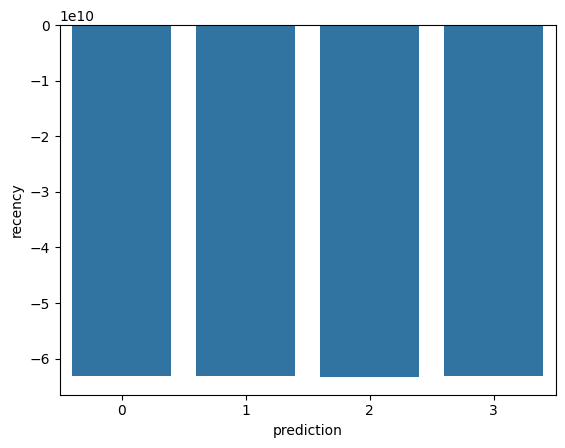

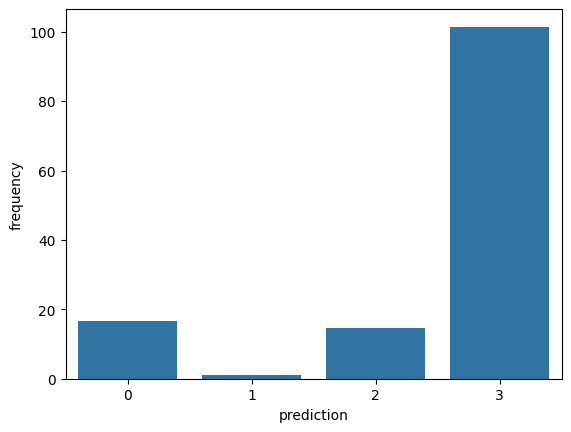

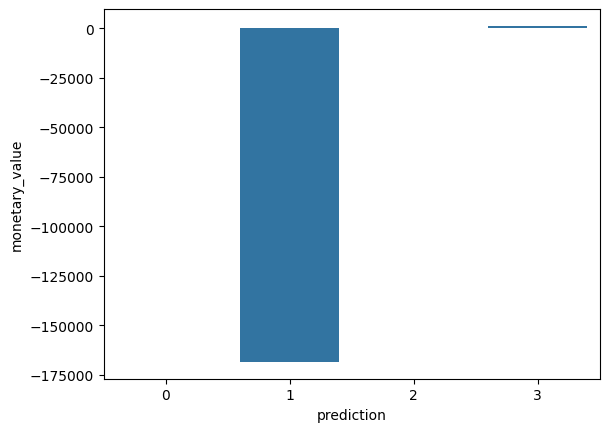

In [35]:
# Cluster Analysis
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

The codes above will render the following plots:

Here is an overview of characteristics displayed by customers in each cluster:

Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.

Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.

Cluster 2: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.
 
Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.